In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
import multiprocessing

# custom functions
from functions import *

2024-11-11 15:30:04.395135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 15:30:04.398950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 15:30:04.409021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731335404.426048   33702 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731335404.430796   33702 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 15:30:04.448213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
df = pd.read_csv('../data/clean/dataset.csv').fillna('')

In [3]:
df

,name,url,title,lemmes,funny
0,liberation,https://www.liberation.fr/international/ameriq...,"A New York, la mairie veut rendre la Ve Avenue...",new york mairie vouloir ve avenue pieton,0
1,liberation,https://www.liberation.fr/forums/vers-une-resp...,Vers une responsabilité sociale et environneme...,responsabilite social environnemental musee,0
2,liberation,https://www.liberation.fr/international/ameriq...,Présidentielle américaine 2024 : à la frontièr...,presidentielle americain frontiere mexicain es...,0
3,liberation,https://www.liberation.fr/forums/mal-logement-...,Mal-logement : «Les luttes des habitants sont ...,mal-logement lutte habitant revendication ecol...,0
4,liberation,https://www.liberation.fr/culture/musique/waru...,"Warum Joe, punk canal historique",warum joe punk canal historique,0
...,...,...,...,...,...
102080,le_parisien,https://www.leparisien.fr/international/etats-...,« Nous avons désormais une chance de gagner »...,desormais chance gagner apres retrait biden de...,0
102081,le_parisien,https://www.leparisien.fr/jo-paris-2024/handba...,"JO Paris 2024, handball : pourquoi le tournoi ...",jo paris handball tournoi terminer lille paris,0
102082,le_parisien,https://www.leparisien.fr/jo-paris-2024/handba...,"JO Paris 2024, handball : quels sont les pays ...",jo paris handball pays titres palmares tournoi...,0
102083,le_parisien,https://www.leparisien.fr/jo-paris-2024/handba...,"JO Paris 2024, handball : le palmarès complet...",jo paris handball palmares complet equipe fran...,0


In [4]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['lemmes'].to_list()
sentences = [simple_preprocess(text) for text in sentences]

In [5]:
w2v_model = Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=314,
                                                # workers=1)
                                               workers=multiprocessing.cpu_count())

In [6]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)

(76790163, 78204400)

In [7]:
model_vectors = w2v_model.wv

In [8]:
w2v_words = model_vectors.index_to_key

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1

In [10]:
# weights matrix
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (47037, 300)


In [11]:
# Model creation

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

/home/michael/.pyenv/versions/3.12.6/envs/funnypress-data-study/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-11 15:32:50.585090: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-11 15:32:50.608796: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56444400 exceeds 10% of free system memory.
2024-11-11 15:32:50.624930: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56444400 exceeds 10% of free system memory.
2024-11-11 15:32:50.636272: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56444400 exceeds 10% of free system memory.
2024-11-11 15:32:50.845967: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56444400 exceeds 10% of free system memor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 24, 300)        │    14,111,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,111,100 (53.83 MB)

 Trainable params: 14,111,100 (53.83 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

  53/3191 ━━━━━━━━━━━━━━━━━━━━ 3s 983us/step 

/home/michael/.pyenv/versions/3.12.6/envs/funnypress-data-study/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1']. Received: the structure of inputs=*
  warnings.warn(


3191/3191 ━━━━━━━━━━━━━━━━━━━━ 3s 888us/step


2024-11-11 15:32:54.729799: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122502000 exceeds 10% of free system memory.


(102085, 300)

<Figure size 800x600 with 0 Axes>

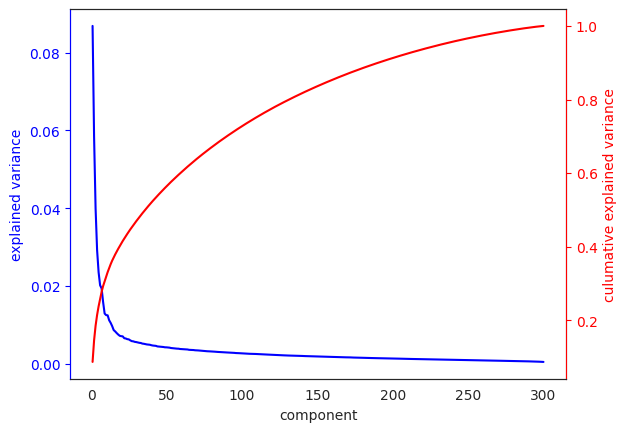

In [13]:
pca_graph(embeddings)

In [14]:
y = df.funny

In [15]:
mapper = umap.UMAP(n_components=2, n_jobs=-1, verbose=1).fit(embeddings)    

UMAP( verbose=1)
Mon Nov 11 15:32:55 2024 Construct fuzzy simplicial set
Mon Nov 11 15:32:55 2024 Finding Nearest Neighbors
Mon Nov 11 15:32:55 2024 Building RP forest with 21 trees
Mon Nov 11 15:33:02 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Mon Nov 11 15:33:16 2024 Finished Nearest Neighbor Search
Mon Nov 11 15:33:19 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 11 15:33:50 2024 Finished embedding


<Axes: >

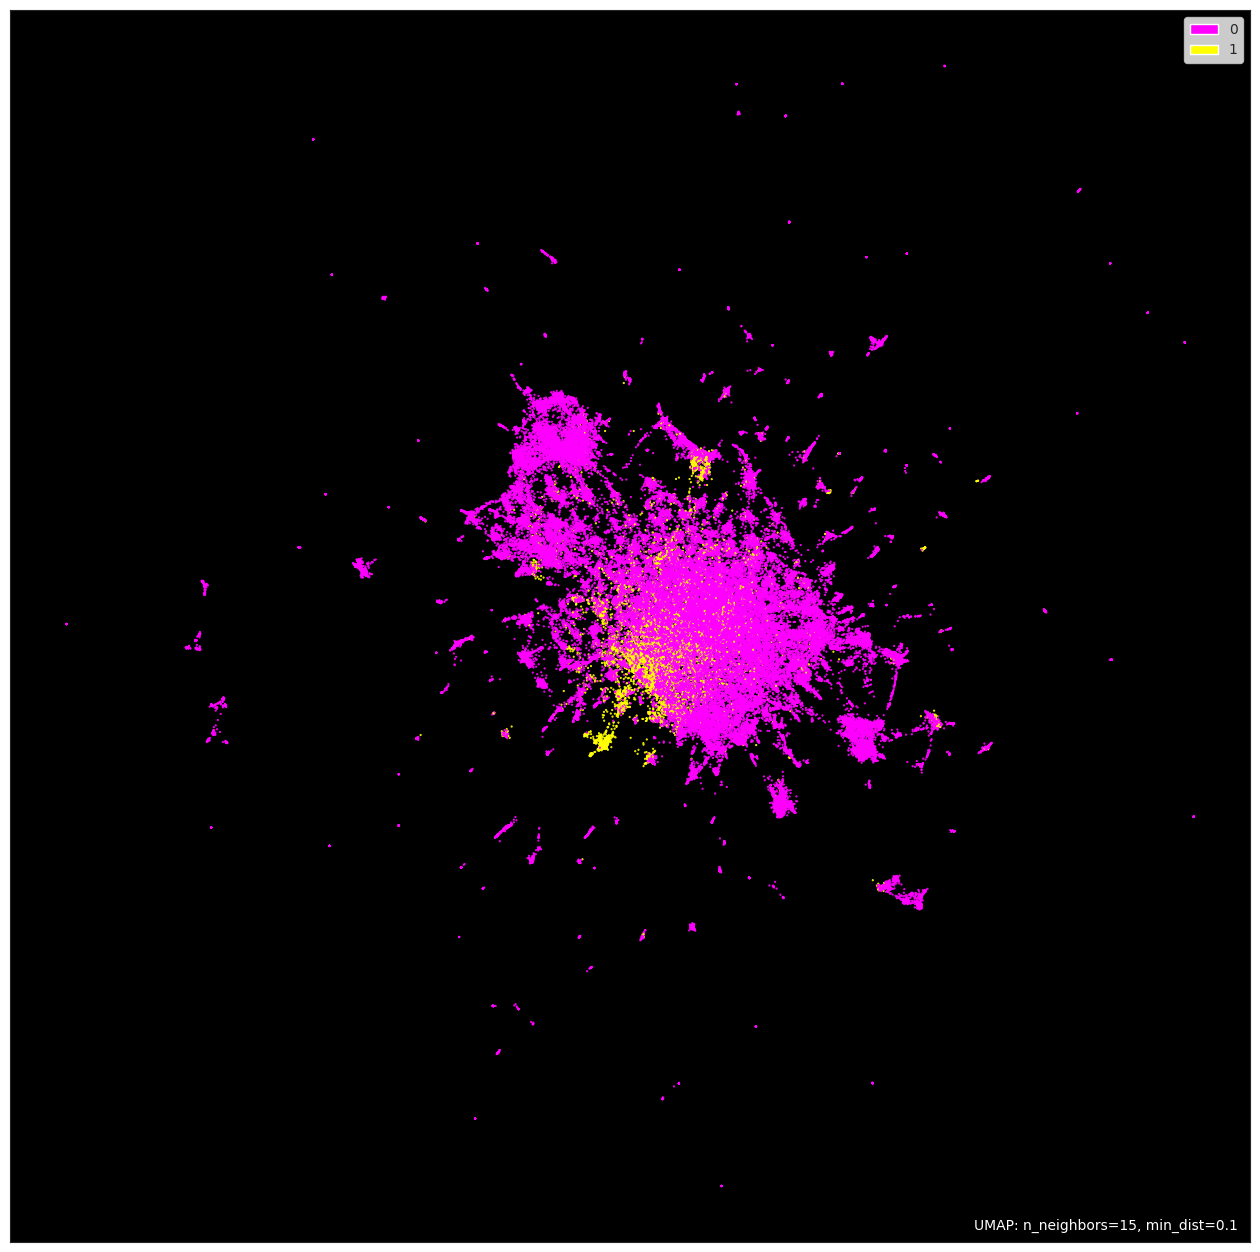

In [16]:
umap.plot.points(mapper, labels=y, background='black', color_key_cmap='spring', width=1600, height=1600)